In [1]:
import sys
from pathlib import Path

parent_dir = Path.cwd().parent  # 获取notebook所在目录的父目录
sys.path.append(str(parent_dir / "script"))  # 将script中的包添加到系统路径
import ternary  # 必须执行上述代码才能导入该包
from ternary.colormapping import get_cmap, colormapper, colorbar_hack

import math 
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from scipy.interpolate import NearestNDInterpolator, RBFInterpolator

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(ternary.__version__)

1.0.8


## 三元图例

参考：https://github.com/marcharper/python-ternary

In [3]:
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(w - y_color) / w
    g = math.fabs(w - x_color) / w
    b = math.fabs(w - z_color) / w
    return (r, g, b, 1.)


def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d

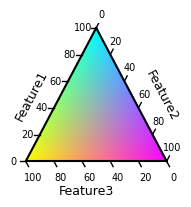

In [4]:
scale = 100  # 该参数跟后续地图数据有关
data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(2, 2)
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False, scientific=True)
tax.ticks(axis='rlb', linewidth=1, clockwise=True, offset=0.04, tick_formats="%0.0f", multiple=20, fontsize=7)
tax.boundary()
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.left_axis_label("Feature1", offset=0.2, color='k', fontsize=9)
tax.right_axis_label("Feature2", offset=0.2, color='k', fontsize=9)
tax.bottom_axis_label("Feature3", offset=0.26, color='k', fontsize=9)

plt.show()

## 构建数据

### 格网

<Axes: >

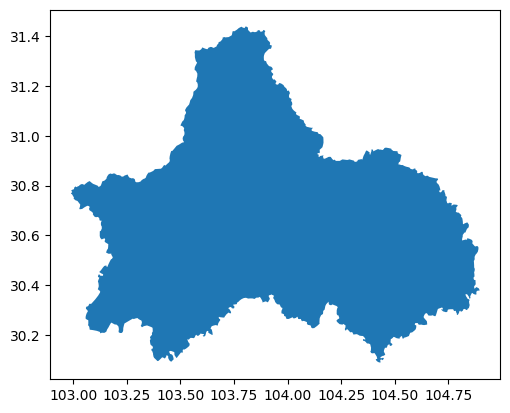

In [5]:
gdf = gpd.read_file('../data/chengdu.geojson')
gdf.plot()

In [6]:
def make_grid(boundary: gpd.GeoDataFrame, radius: float) -> gpd.GeoDataFrame:
    # 以边界的中心点按照radius半径进行外扩
    minx, miny, maxx, maxy = boundary.total_bounds
    deltax = ((maxx-minx)%(radius*2)) / 2
    deltay = ((maxy-miny)%(radius*2)) / 2
    minx -= deltax
    maxx += deltax
    miny -= deltay
    maxy += deltay
    cells = []
    for x in np.arange(minx, maxx, radius*2):
        for y in np.arange(miny, maxy, radius*2):
            cells.append(Polygon([(x,y),(x,y+radius*2),(x+radius*2,y+radius*2),(x+radius*2,y),(x,y)]))
    return gpd.GeoDataFrame(cells,columns=['geometry'],crs=boundary.crs).sjoin(boundary,how='inner') 

def generate_data(gdf, select_num=100, scale=100, col='Feature'):
    selected_indices = np.random.choice(gdf.index, select_num, replace=False)
    selected_gdf = gdf.loc[selected_indices].copy()
    selected_gdf['value'] = np.random.uniform(0, scale, select_num) # 生成浮点数

    # 提取选定格网的中心坐标和值
    # 注意：几何中心可能不是最佳选择，但对于均匀格网通常可行。
    # 对于非均匀格网，可能需要更精细的质心计算或使用格网的质心。
    selected_coords = np.array([[p.x, p.y] for p in selected_gdf.geometry.centroid])
    selected_values = selected_gdf['value'].values
    all_grid_coords = np.array([[p.x, p.y] for p in gdf.geometry.centroid])  # 提取所有格网的中心坐标，作为插值目标点

    # 径向基函数 (RBF) 插值
    # 通常比最近邻平滑，有多种核函数可选
    # 常用核函数: 'gaussian', 'linear', 'cubic', 'multiquadric', 'inverse_multiquadric'
    interpolator_rbf = RBFInterpolator(selected_coords, selected_values, kernel='linear')
    gdf[col] = interpolator_rbf(all_grid_coords)
    gdf[gdf[col]<0][col] = 0
    return gdf[[col]]

In [7]:
grid = make_grid(gdf, 0.01/2)  
grid = grid.drop(columns='index_right').reset_index(drop=True)

# 添加 FID 用于数值连接
grid['FID'] = grid.index

grid

,geometry,地级码,地级,省级,省级码,FID
0,"POLYGON ((102.98630 30.75759, 102.98630 30.767...",510100,成都市,四川省,510000,0
1,"POLYGON ((102.98630 30.76759, 102.98630 30.777...",510100,成都市,四川省,510000,1
2,"POLYGON ((102.98630 30.77759, 102.98630 30.787...",510100,成都市,四川省,510000,2
3,"POLYGON ((102.99630 30.73759, 102.99630 30.747...",510100,成都市,四川省,510000,3
4,"POLYGON ((102.99630 30.74759, 102.99630 30.757...",510100,成都市,四川省,510000,4
...,...,...,...,...,...,...
13963,"POLYGON ((104.88630 30.37759, 104.88630 30.387...",510100,成都市,四川省,510000,13963
13964,"POLYGON ((104.88630 30.38759, 104.88630 30.397...",510100,成都市,四川省,510000,13964
13965,"POLYGON ((104.88630 30.52759, 104.88630 30.537...",510100,成都市,四川省,510000,13965
13966,"POLYGON ((104.88630 30.53759, 104.88630 30.547...",510100,成都市,四川省,510000,13966


<Axes: >

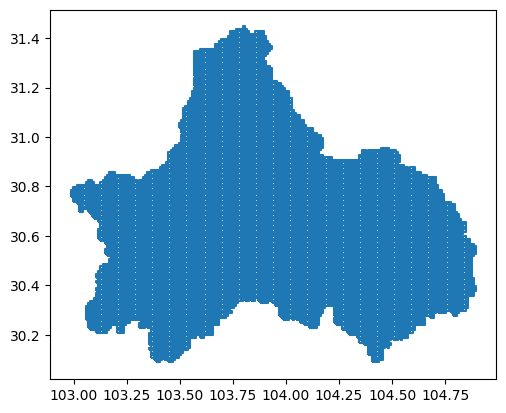

In [8]:
grid.boundary.plot()

### 插值

In [9]:
select_num = 50

grid['Feature1'] = generate_data(grid, select_num=select_num, scale=scale, col='Feature1')
grid['Feature2'] = generate_data(grid, select_num=select_num, scale=scale, col='Feature2')
grid['Feature3'] = generate_data(grid, select_num=select_num, scale=scale, col='Feature3')
grid

,geometry,地级码,地级,省级,省级码,FID,Feature1,Feature2,Feature3
0,"POLYGON ((102.98630 30.75759, 102.98630 30.767...",510100,成都市,四川省,510000,0,1.858606,65.058736,41.490653
1,"POLYGON ((102.98630 30.76759, 102.98630 30.777...",510100,成都市,四川省,510000,1,1.893677,65.308756,41.392455
2,"POLYGON ((102.98630 30.77759, 102.98630 30.787...",510100,成都市,四川省,510000,2,1.930865,65.507631,41.300079
3,"POLYGON ((102.99630 30.73759, 102.99630 30.747...",510100,成都市,四川省,510000,3,2.094485,65.244684,41.599346
4,"POLYGON ((102.99630 30.74759, 102.99630 30.757...",510100,成都市,四川省,510000,4,2.136439,65.599140,41.477356
...,...,...,...,...,...,...,...,...,...
13963,"POLYGON ((104.88630 30.37759, 104.88630 30.387...",510100,成都市,四川省,510000,13963,84.460239,34.193767,14.290070
13964,"POLYGON ((104.88630 30.38759, 104.88630 30.397...",510100,成都市,四川省,510000,13964,85.893025,33.253572,14.357767
13965,"POLYGON ((104.88630 30.52759, 104.88630 30.537...",510100,成都市,四川省,510000,13965,82.078994,16.326137,15.767125
13966,"POLYGON ((104.88630 30.53759, 104.88630 30.547...",510100,成都市,四川省,510000,13966,83.738933,15.506078,15.986074


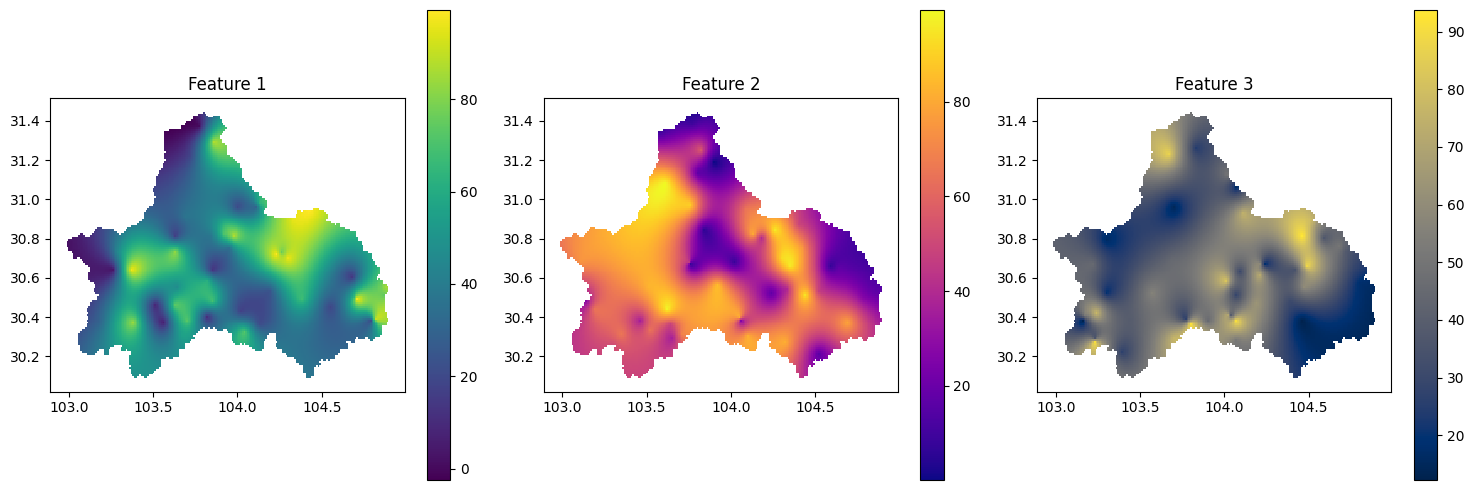

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

grid.plot(column='Feature1', ax=ax[0], legend=True, cmap='viridis')
ax[0].set_title('Feature 1') # Optional: Add a title to the subplot
grid.plot(column='Feature2', ax=ax[1], legend=True, cmap='plasma')
ax[1].set_title('Feature 2')
grid.plot(column='Feature3', ax=ax[2], legend=True, cmap='cividis')
ax[2].set_title('Feature 3')

plt.tight_layout() 
plt.show()

In [11]:
# 获取rgb三原色
grid['rgb'] = grid.apply(
    lambda row: color_point(
        row['Feature1'],
        row['Feature2'],
        row['Feature3'],
        scale=scale
    ),
    axis=1
)

grid

,geometry,地级码,地级,省级,省级码,FID,Feature1,Feature2,Feature3,rgb
0,"POLYGON ((102.98630 30.75759, 102.98630 30.767...",510100,成都市,四川省,510000,0,1.858606,65.058736,41.490653,"(0.34941263633893593, 0.9814139421446834, 0.58..."
1,"POLYGON ((102.98630 30.76759, 102.98630 30.777...",510100,成都市,四川省,510000,1,1.893677,65.308756,41.392455,"(0.3469124393076327, 0.9810632279263265, 0.586..."
2,"POLYGON ((102.98630 30.77759, 102.98630 30.787...",510100,成都市,四川省,510000,2,1.930865,65.507631,41.300079,"(0.3449236867594425, 0.9806913547157462, 0.586..."
3,"POLYGON ((102.99630 30.73759, 102.99630 30.747...",510100,成都市,四川省,510000,3,2.094485,65.244684,41.599346,"(0.3475531627505996, 0.9790551479309829, 0.584..."
4,"POLYGON ((102.99630 30.74759, 102.99630 30.757...",510100,成都市,四川省,510000,4,2.136439,65.599140,41.477356,"(0.34400859933129885, 0.9786356057798928, 0.58..."
...,...,...,...,...,...,...,...,...,...,...
13963,"POLYGON ((104.88630 30.37759, 104.88630 30.387...",510100,成都市,四川省,510000,13963,84.460239,34.193767,14.290070,"(0.6580623283089586, 0.15539761089291013, 0.85..."
13964,"POLYGON ((104.88630 30.38759, 104.88630 30.397...",510100,成都市,四川省,510000,13964,85.893025,33.253572,14.357767,"(0.6674642847956034, 0.14106975355938972, 0.85..."
13965,"POLYGON ((104.88630 30.52759, 104.88630 30.537...",510100,成都市,四川省,510000,13965,82.078994,16.326137,15.767125,"(0.8367386345941259, 0.17921005668072468, 0.84..."
13966,"POLYGON ((104.88630 30.53759, 104.88630 30.547...",510100,成都市,四川省,510000,13966,83.738933,15.506078,15.986074,"(0.8449392219873403, 0.16261066785309117, 0.84..."


## 绘制三元图

### Map1

ValueError: RGBA values should be within 0-1 range

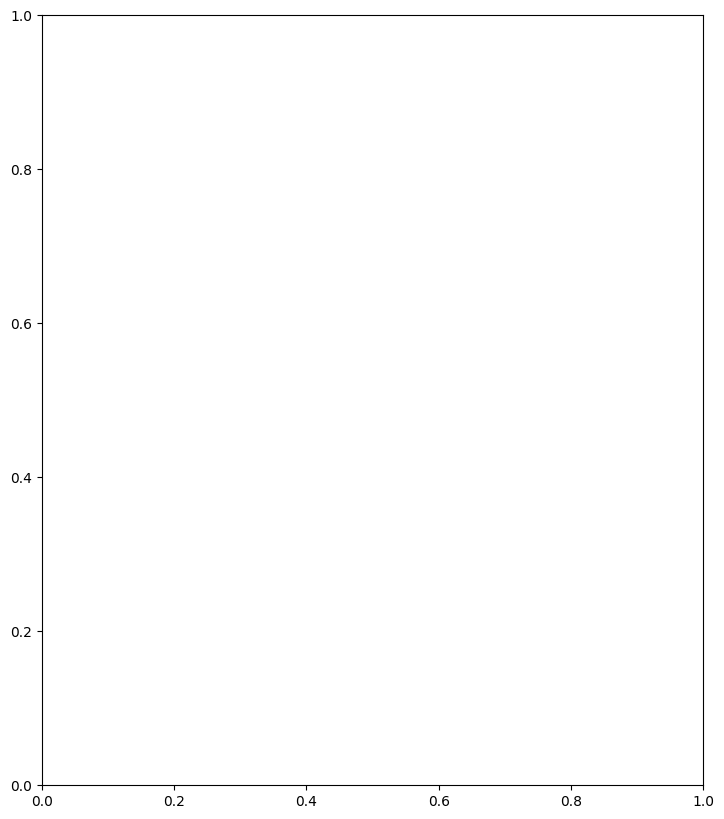

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

grid.plot(ax=ax, color=grid['rgb'])  # 主地图
inset_ax = inset_axes(ax, width="20%", height="20%", loc='upper right', borderpad=2)  # 创建子图

# 子图
scale = 100
data = generate_heatmap_data(scale)
tax = ternary.TernaryAxesSubplot(ax=inset_ax, scale=scale)
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False, scientific=True)
tax.ticks(axis='rlb', linewidth=0.5, clockwise=True, offset=0.04, tick_formats="%0.0f", multiple=20, fontsize=7)
tax.boundary(linewidth=0.5)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.left_axis_label("Feature1", offset=0.2, color='k', fontsize=9)
tax.right_axis_label("Feature2", offset=0.2, color='k', fontsize=9)
tax.bottom_axis_label("Feature3", offset=0.26, color='k', fontsize=9)

tax._redraw_labels()  # 可选：如果标签未正确渲染

plt.show()

### Map2

In [ ]:
def color_point(x, y, z, scale):
    w = 255.0
    x_scaled = x * w / scale
    y_scaled = y * w / scale
    z_scaled = z * w / scale

    # 构建 YGB 映射（黄色 = 红+绿）
    r = x_scaled / w                           
    g = min(1.0, (x_scaled + y_scaled) / w)    
    b = z_scaled / w                           

    return (round(r, 3), round(g, 3), round(b, 3), 1.0)

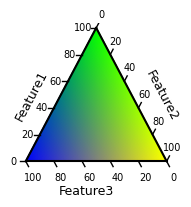

In [ ]:
scale = 100  # 该参数跟后续地图数据有关
data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(2, 2)
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False, scientific=True)
tax.ticks(axis='rlb', linewidth=1, clockwise=True, offset=0.04, tick_formats="%0.0f", multiple=20, fontsize=7)
tax.boundary()
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.left_axis_label("Feature1", offset=0.2, color='k', fontsize=9)
tax.right_axis_label("Feature2", offset=0.2, color='k', fontsize=9)
tax.bottom_axis_label("Feature3", offset=0.26, color='k', fontsize=9)

plt.show()

In [ ]:
grid['rgb'] = grid.apply(
    lambda row: color_point(
        row['Feature1'],
        row['Feature2'],
        row['Feature3'],
        scale=scale
    ),
    axis=1
)

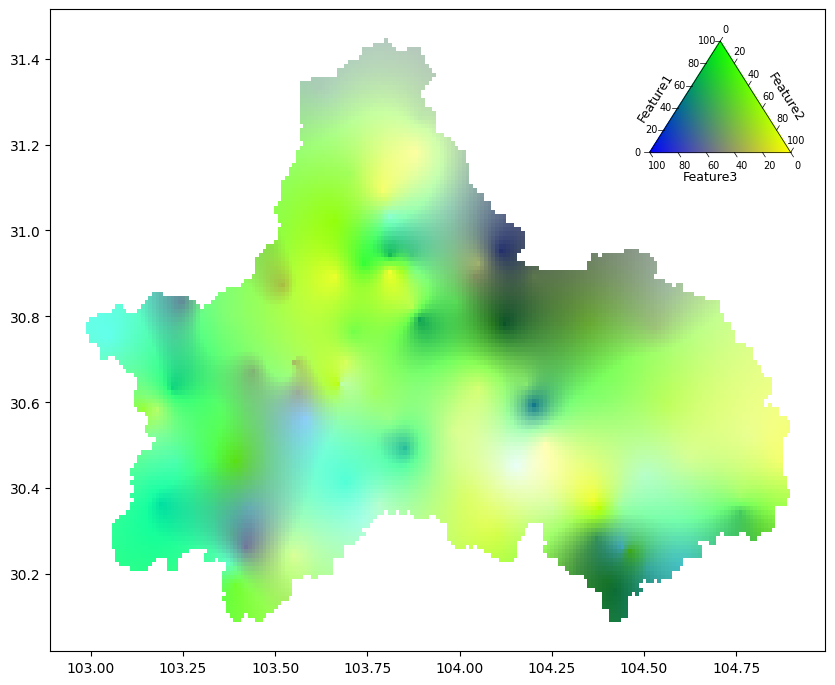

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

grid.plot(ax=ax, color=grid['rgb'])  # 主地图
inset_ax = inset_axes(ax, width="20%", height="20%", loc='upper right', borderpad=2)  # 创建子图

# 子图
scale = 100
data = generate_heatmap_data(scale)
tax = ternary.TernaryAxesSubplot(ax=inset_ax, scale=scale)
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False, scientific=True)
tax.ticks(axis='rlb', linewidth=0.5, clockwise=True, offset=0.04, tick_formats="%0.0f", multiple=20, fontsize=7)
tax.boundary(linewidth=0.5)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.left_axis_label("Feature1", offset=0.2, color='k', fontsize=9)
tax.right_axis_label("Feature2", offset=0.2, color='k', fontsize=9)
tax.bottom_axis_label("Feature3", offset=0.26, color='k', fontsize=9)

tax._redraw_labels()  # 可选：如果标签未正确渲染

plt.show()

### Map3

In [ ]:
def color_point(x, y, z, scale):
    w = 255.0
    x_scaled = x * w / scale   # 红
    y_scaled = y * w / scale   # 蓝
    z_scaled = z * w / scale   # 灰

    gray = z_scaled / w * 0.8  # 灰色权重系数

    r = min(1.0, x_scaled / w + gray)
    g = gray
    b = min(1.0, y_scaled / w + gray)

    return (round(r, 3), round(g, 3), round(b, 3), 1.0)


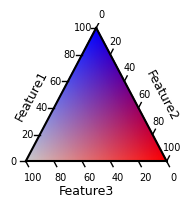

In [ ]:
scale = 100  # 该参数跟后续地图数据有关
data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(2, 2)
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False, scientific=True)
tax.ticks(axis='rlb', linewidth=1, clockwise=True, offset=0.04, tick_formats="%0.0f", multiple=20, fontsize=7)
tax.boundary()
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.left_axis_label("Feature1", offset=0.2, color='k', fontsize=9)
tax.right_axis_label("Feature2", offset=0.2, color='k', fontsize=9)
tax.bottom_axis_label("Feature3", offset=0.26, color='k', fontsize=9)

plt.show()

In [ ]:
grid['rgb'] = grid.apply(
    lambda row: color_point(
        row['Feature1'],
        row['Feature2'],
        row['Feature3'],
        scale=scale
    ),
    axis=1
)

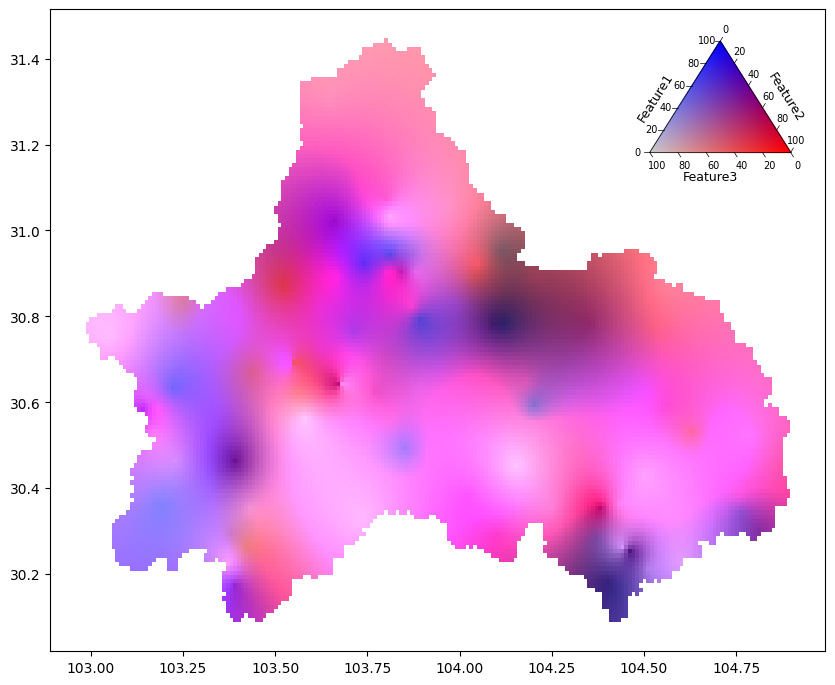

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

grid.plot(ax=ax, color=grid['rgb'])  # 主地图
inset_ax = inset_axes(ax, width="20%", height="20%", loc='upper right', borderpad=2)  # 创建子图

# 子图
scale = 100
data = generate_heatmap_data(scale)
tax = ternary.TernaryAxesSubplot(ax=inset_ax, scale=scale)
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False, scientific=True)
tax.ticks(axis='rlb', linewidth=0.5, clockwise=True, offset=0.04, tick_formats="%0.0f", multiple=20, fontsize=7)
tax.boundary(linewidth=0.5)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.left_axis_label("Feature1", offset=0.2, color='k', fontsize=9)
tax.right_axis_label("Feature2", offset=0.2, color='k', fontsize=9)
tax.bottom_axis_label("Feature3", offset=0.26, color='k', fontsize=9)

tax._redraw_labels()  # 可选：如果标签未正确渲染

plt.show()

### Map4